### Imports and helper functions

In [1]:
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from itertools import cycle
from scipy.optimize import linear_sum_assignment

In [2]:
def visualize_points(pts):
    plt.plot(pts[:, 0], pts[:, 1], '.', alpha=0.5)
    plt.axis('equal')
    plt.grid()

    return plt

In [3]:
def create_ellipse_points(mean, cov, n_std=1.96, n_points=100):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    
    t = np.linspace(0, 2*np.pi, n_points)
    ellipse_x = n_std * np.sqrt(eigenvalues[0]) * np.cos(t)
    ellipse_y = n_std * np.sqrt(eigenvalues[1]) * np.sin(t)
    
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    
    ellipse_points = np.dot(np.column_stack([ellipse_x, ellipse_y]), R.T) + mean
    return ellipse_points[:, 0], ellipse_points[:, 1]

def plot_confidence_ellipses(distributions, n_std=1.96):
    fig, ax = plt.subplots()

    cmap = plt.get_cmap('viridis')
    colors = cycle(cmap(np.linspace(0, 1, len(distributions))))
    patches = []

    for idx, dist in enumerate(distributions):
        mean, cov = dist[0], np.array([dist[1], dist[2]])
        x, y = create_ellipse_points(mean, cov, n_std)
        
        color = next(colors)
        
        # Create polygon
        polygon_points = np.column_stack([x, y])
        poly = Polygon(polygon_points, closed=True, fill=True, color=color, alpha=0.5)
        ax.add_patch(poly)
        patches.append(poly)

    ax.set_title('Confidence Ellipses')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(patches, ['Distribution {}'.format(i) for i in range(len(distributions))])
    ax.axis('equal')

    return plt, ax

def plot_distributions_with_points(distributions, points, n_std=1.96):
    fig, ax = plot_confidence_ellipses(distributions, n_std)
    
    ax.plot(points[:, 0], points[:, 1], 'ko')

    return plt

def plot_distributions_with_colored_points(distributions, points, points_to_distribution, n_std=1.96):
    fig, ax = plot_confidence_ellipses(distributions, n_std)
    
    # Plot all points in a default color (black)
    ax.plot(points[:, 0], points[:, 1], 'ko', label='All Points')

    # Use the same colormap to get consistent colors
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(distributions)))

    for dist_idx, point_idx in enumerate(points_to_distribution):
        ax.plot(points[point_idx, 0], points[point_idx, 1], 'o', color=colors[dist_idx], label=f'Point to Distribution {dist_idx}')
    
    ax.legend()
    return plt, ax

### Code

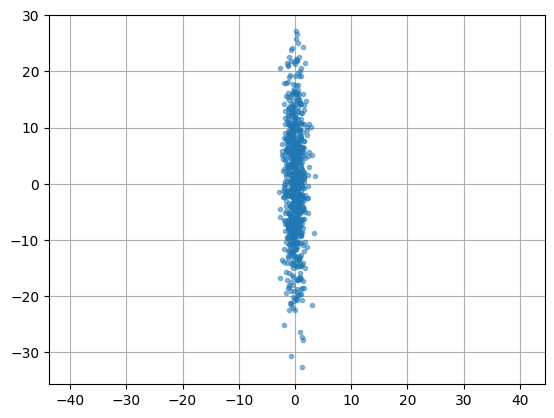

In [4]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]
pts = np.random.multivariate_normal(mean, cov, size=800)

visualize_points(pts).show()

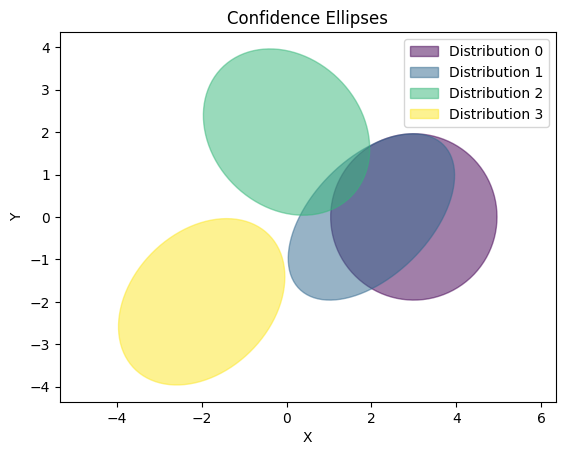

In [5]:
# each row has the values for mutlivariate normal distributions
distributions = np.array([
    [[3, 0], [1, 0], [0, 1]],
    [[2, 0], [1, 0.5], [0.5, 1]],
    [[0, 2], [1, -0.2], [-0.2, 1]],
    [[-2, -2], [1, 0.3], [0.3, 1]]
])

plot_confidence_ellipses(distributions)[0].show()

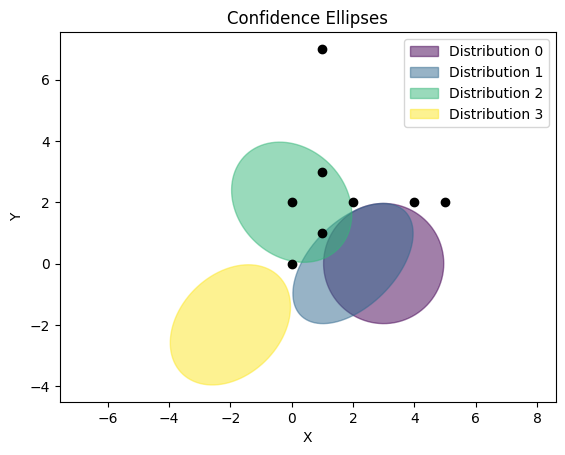

In [6]:
points = np.array([
    [0, 0],
    [1, 1],
    [2, 2],
    [4, 2],
    [1, 3],
    [0, 2],
    [1, 7],
    [5, 2]
])

plot_distributions_with_points(distributions, points).show()

### Points to Distribution

In [7]:
from scipy.stats import multivariate_normal

def calc_likelihoods_for_distributions_and_points(matrix_dist, matrix_points):
    means = distributions[:, 0]
    covariances = distributions[:, 1:]
    likelihoods = np.array([multivariate_normal(mean=means[i], cov=covariances[i]).pdf(points) for i in range(len(means))])
    
    return likelihoods.T 

In [ ]:
def calc_point_indices_to_distributions(distributions, points):
    likelihoods = calc_likelihoods_for_distributions_and_points(distributions, points)
    sorted_indices = np.argsort(likelihoods, axis=0)
    ranks = np.zeros_like(likelihoods, dtype=int)
    n_rows, n_cols = likelihoods.shape
    ranks[sorted_indices, np.arange(n_cols)] = np.tile(np.arange(n_rows), (n_cols, 1)).T
    
    mask_binary = np.array((n_rows - ranks) <= n_cols, dtype=int)
    mask_int = np.copy(mask_binary)
    mask_int[:, 1] *= 2
    mask_int[:, 2] *= 3
    mask_int[:, 3] *= 4
    cumsum_array = np.cumsum(mask_binary, axis=0)
    
    s = min(n_rows, n_cols)
    extended_likelihood_entries = np.zeros((s+1, n_cols + 1))
    
    mask  = np.array((n_rows - ranks) <= n_cols)
    
    points_to_consider = np.where(np.any(mask, axis=1))[0]
    filtered_points = points[points_to_consider]
    
    likelihood_entries = calc_likelihoods_for_distributions_and_points(distributions, filtered_points)
    
    percentage_of_likelihood = np.log(likelihood_entries)/ np.sum(np.log(likelihood_entries), axis=0)
    
    cost_matrix = np.log(percentage_of_likelihood)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    max_index = max(col_ind) + 1  # Assuming indices start from 0.
    points_to_distributions = np.empty(max_index, dtype=row_ind.dtype)
    
    points_to_distributions[col_ind] = row_ind
    return points_to_distributions

In [8]:
distributions = np.array([
    [[3, 0], [1, 0], [0, 1]],
    [[2, 0], [1, 0.5], [0.5, 1]],
    [[0, 2], [1, -0.2], [-0.2, 1]],
    [[-2, -2], [1, 0.3], [0.3, 1]]
])

points = np.array([
    [0, 0],
    [1, 1],
    [2, 2],
    [4, 2],
    [1, 3],
    [0, 2],
    [1, 7],
    [5, 2]
])


likelihoods = calc_likelihoods_for_distributions_and_points(distributions, points)
sorted_indices = np.argsort(likelihoods, axis=0)
ranks = np.zeros_like(likelihoods, dtype=int)
n_rows, n_cols = likelihoods.shape
ranks[sorted_indices, np.arange(n_cols)] = np.tile(np.arange(n_rows), (n_cols, 1)).T

mask_binary = np.array((n_rows - ranks) <= n_cols, dtype=int)
mask_int = np.copy(mask_binary)
mask_int[:, 1] *= 2
mask_int[:, 2] *= 3
mask_int[:, 3] *= 4
cumsum_array = np.cumsum(mask_binary, axis=0)

s = min(n_rows, n_cols)
extended_likelihood_entries = np.zeros((s+1, n_cols + 1))

mask  = np.array((n_rows - ranks) <= n_cols)

# indices = np.column_stack((mask_int.flatten(), cumsum_array.flatten()))
points_to_consider = np.where(np.any(mask, axis=1))[0]
filtered_points = points[points_to_consider]

likelihood_entries = calc_likelihoods_for_distributions_and_points(distributions, filtered_points)
# flat_likelihoods = likelihoods.flatten()

# extended_likelihood_entries[indices[:, 1], indices[:, 0]] = flat_likelihoods
# likelihood_entries = extended_likelihood_entries[1:, 1:]

percentage_of_likelihood = np.log(likelihood_entries)/ np.sum(np.log(likelihood_entries), axis=0)
percentage_of_likelihood

array([[0.09027927, 0.05261109, 0.06876415, 0.03324583],
       [0.06179047, 0.04456788, 0.04672887, 0.05951492],
       [0.06179047, 0.05261109, 0.06876415, 0.09629164],
       [0.06179047, 0.05261109, 0.17894051, 0.15333309],
       [0.11876807, 0.125     , 0.05407396, 0.10604873],
       [0.11876807, 0.11695679, 0.03203869, 0.06927201],
       [0.40365612, 0.47890135, 0.28911688, 0.28918179],
       [0.08315707, 0.07674073, 0.26157279, 0.19311199]])

In [9]:
cost_matrix = np.log(percentage_of_likelihood)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

row_ind, col_ind

(array([0, 1, 2, 5]), array([3, 1, 0, 2]))

In [10]:
max_index = max(col_ind) + 1  # Assuming indices start from 0.
points_to_distributions = np.empty(max_index, dtype=row_ind.dtype)

points_to_distributions[col_ind] = row_ind
points_to_distributions

array([2, 1, 5, 0])

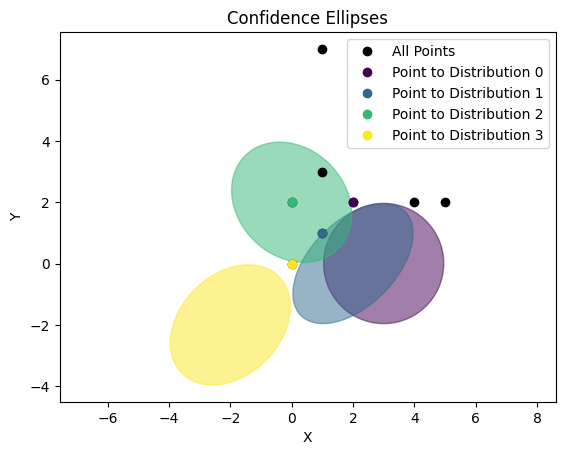

In [22]:
plt, ax = plot_distributions_with_colored_points(distributions, points, points_to_distributions, n_std=1.96)
plt.show()

### Assign points to distributions

Give a set of $N$ multivariate normal distributions and a set of $M$ points ${(x_i,y_i)}_{M}$. The problem we want to solve can be formulated as:
- find a subset of points 

### Gaussian Processes